In [8]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lbc.experiments.runner import SCENARIO_DEFAULT

%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%autoreload 2
from lbc.analysis import run_analysis, plot_costs

In [10]:
%autoreload 2
from lbc.experiments import (
    DPCRunner, MPCOneShotRunner, MPCRunner, RLCRunner, CPLRunner)

In [11]:
%autoreload
from configs import make_configs

In [12]:
dr = "PC"
configs = make_configs(dr, batch_size=2, lookahead=4)

# MPCOneShot

In [13]:
config = configs["MPCOneShot"]
config["policy_config"]["tee"] = True # turn on solver logging
print(config)

{'name': 'MPCOneShot-PC-test', 'policy_type': 'MPCOneShot', 'dr_program': 'PC', 'batch_size': 2, 'scenario_config': {'start_time': '00:05:00', 'end_time': '23:55:00', 'zone_temp_init_mean': 26.0, 'dr_program': <lbc.demand_response.DemandResponseProgram object at 0x7fed8bb49430>}, 'policy_config': {'tee': True}, 'training': False, 'dry_run': 0, 'results_dir': './_scratch'}


In [14]:
runner0 = MPCOneShotRunner(**config)
loss0, rollout0, meta0 = runner0.run()

INFO:/Users/dbiagion/gitrepos/learning-building-control/lbc/policies/mpc.py:one-shot: batch sample (1/2)


Ipopt 3.14.4: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    30392
Number of nonzeros in inequality constraint Jacobian.:     9758
Number of nonzeros in Lagrangian Hessian.............:    10332

Total number of variables............................:    14350
                     variables with only lower bounds:     3444
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     9471
Total number o

  79  1.5214803e+03 8.44e-03 1.43e-02  -5.7 1.03e+00  -3.3 1.46e-01 7.02e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.5214801e+03 8.38e-03 9.87e-03  -5.7 2.02e+01  -3.8 1.02e-01 7.69e-03h  1
  81  1.5214782e+03 5.53e-03 1.77e-02  -5.7 1.06e+00  -3.4 5.53e-02 3.41e-01f  1
  82  1.5214770e+03 3.07e-03 7.17e-03  -5.7 6.09e-01  -3.0 1.00e+00 4.44e-01f  1
  83  1.5214728e+03 2.58e-03 5.60e-03  -5.7 1.97e+00  -3.4 1.57e-01 5.85e-01f  1
  84  1.5214700e+03 1.27e-03 2.20e-03  -5.7 7.86e-01  -3.0 1.00e+00 8.18e-01f  1
  85  1.5214686e+03 9.65e-04 6.44e-03  -5.7 2.57e+00  -3.5 5.25e-01 1.94e-01f  1
  86  1.5214664e+03 9.79e-04 4.44e-03  -5.7 8.22e-01  -3.1 1.00e+00 6.80e-01f  1
  87  1.5214627e+03 4.80e-03 5.39e-03  -5.7 4.11e+00  -3.5 5.28e-01 2.81e-01h  1
  88  1.5214585e+03 3.77e-03 9.23e-03  -5.7 1.20e+00  -3.1 9.71e-02 8.41e-01f  1
  89  1.5214554e+03 5.33e-03 8.01e-03  -5.7 7.73e+00  -3.6 2.78e-01 9.75e-02f  1
iter    objective    inf_pr 

INFO:/Users/dbiagion/gitrepos/learning-building-control/lbc/policies/mpc.py:one-shot: batch sample (2/2)


Ipopt 3.14.4: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    30392
Number of nonzeros in inequality constraint Jacobian.:     9758
Number of nonzeros in Lagrangian Hessian.............:    10332

Total number of variables............................:    14350
                     variables with only lower bounds:     3444
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     9471
Total number o

  78  2.3899056e+03 6.79e-03 1.69e-02  -5.7 1.25e+00  -3.3 5.84e-01 3.06e-01h  1
  79  2.3899050e+03 5.66e-03 2.60e-02  -5.7 4.09e-01  -2.9 1.00e+00 1.67e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  2.3899011e+03 2.73e-03 1.21e-02  -5.7 1.41e+00  -3.3 1.90e-01 5.17e-01h  1
  81  2.3899006e+03 2.32e-03 1.13e-02  -5.7 4.96e-01  -2.9 5.49e-01 1.51e-01f  1
  82  2.3899002e+03 2.20e-03 1.27e-02  -5.7 1.09e+00  -3.4 1.54e-01 5.38e-02f  1
  83  2.3898991e+03 1.29e-03 6.31e-03  -5.7 3.78e-01  -3.0 1.46e-01 4.11e-01f  1
  84  2.3898974e+03 9.89e-04 4.79e-03  -5.7 1.74e+00  -3.4 2.50e-01 2.36e-01f  1
  85  2.3898958e+03 4.50e-04 3.15e-03  -5.7 5.05e-01  -3.0 4.33e-01 5.45e-01f  1
  86  2.3898943e+03 4.16e-04 2.00e-03  -5.7 2.41e+00  -3.5 2.04e-01 1.29e-01f  1
  87  2.3898930e+03 3.55e-04 1.30e-03  -5.7 7.10e-01  -3.1 3.45e-01 3.53e-01f  1
  88  2.3898908e+03 2.77e-03 1.92e-03  -5.7 5.26e+00  -3.5 2.43e-01 1.79e-01f  1
  89  2.3898872e+03 3.11e-03

INFO:lbc.experiments.runner:[MPCOneShot-PC-test] bsz=2, loss=1955.602, time=42.2
INFO:lbc.experiments.runner:saved to ./_scratch/MPCOneShot-PC-test.p


In [15]:
# As a sanity check, we can compare the planned zone temp in MPC and 
# the realized (rollout) zone temp.  They should be quite close since
# MPC has an idealized model of dynamics and exogenous variables.

df = meta0["df"][0]
z1 = df[[x for x in df.columns if x.startswith("zone_temp")]]

z2 = rollout0.data["zone_temp"][:, 0, :].squeeze()

relerr = np.linalg.norm(z1-z2) / np.linalg.norm(z1) * 100.
print(f"relative error: {relerr:.1f}%")

relative error: 0.3%


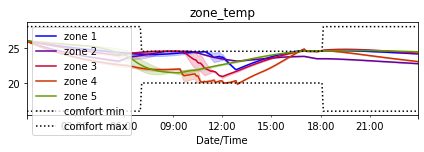

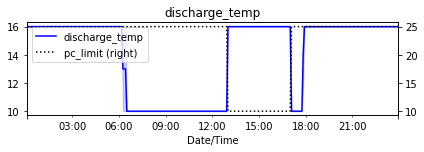

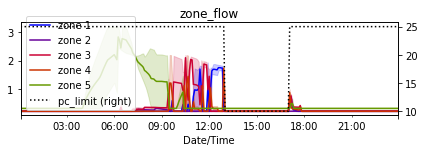

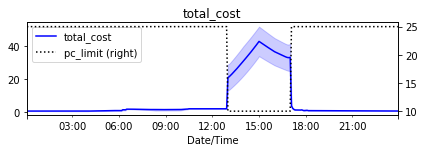

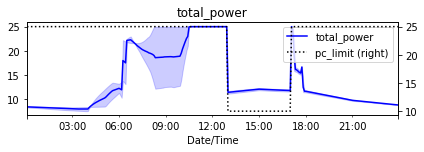

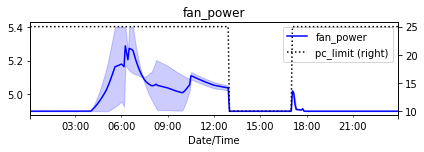

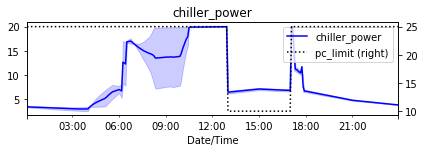

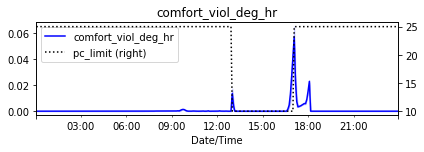

In [16]:
_, df, figs = run_analysis(rollout0, dr, secondary=True)

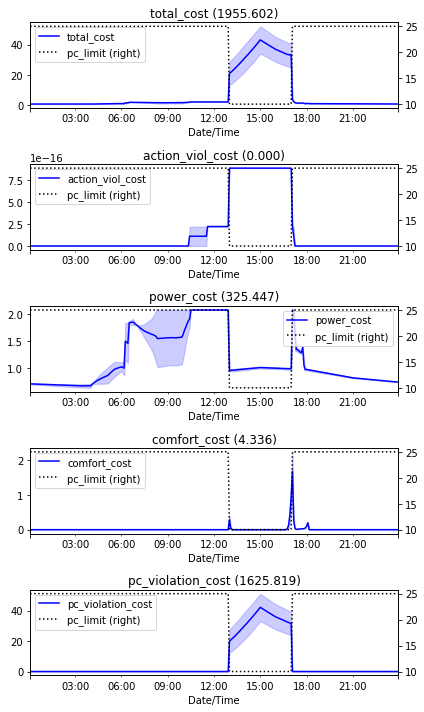

In [18]:
_ = plot_costs(rollout0, secondary="pc_limit")

# MPC

In [83]:
config = configs["MPC"]

runner1 = MPCRunner(**config)
loss1, rollout1, meta1 = runner1.run()

_, df, figs = run_analysis(rollout1, dr, secondary=True)

 48%|█████████████████████████████████████████████▊                                                  | 137/287 [02:53<03:09,  1.26s/it]

KeyboardInterrupt



# CPL - No learning

In [ ]:
config = configs["CPL"]
config

In [ ]:
runner2 = CPLRunner(**config)
loss2, rollout2, meta2 = runner2.run()

_, df, figs = run_analysis(rollout2, dr, secondary=True)

# CPL - Learning

In [25]:
config = configs["CPL"]
config["policy_config"]["use_value_function"] = 1
config["policy_config"]["num_epochs"] = 10  # increase this if truly trying to train
config

{'name': 'CPL-PC-test',
 'policy_type': 'CPL',
 'batch_size': 31,
 'dr_program': 'PC',
 'scenario_config': {'start_time': '00:05:00',
  'end_time': '23:55:00',
  'zone_temp_init_mean': 26.0,
  'dr_program': <lbc.demand_response.DemandResponseProgram at 0x7f8504422700>},
 'policy_config': {'lookahead': 4,
  'lr': 10,
  'num_epochs': 10,
  'use_value_function': 1,
  'num_time_windows': 24},
 'training': True,
 'dry_run': 0,
 'results_dir': './_scratch'}

/Users/dbiagion/miniconda3/envs/lbc/lib/python3.8/site-packages/cvxpy/expressions/expression.py:558: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)
9.126, 13.265 1.000e+01: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [43:09<00:00, 258.98s/it]
INFO:lbc.experiments.runner:[CPL-PC-test] bsz=31, loss=12.738, time=6068.8
INFO:lbc.experiments.runner:saved to ./_scratch/CPL-PC-test.p


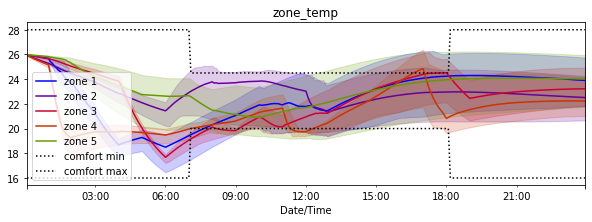

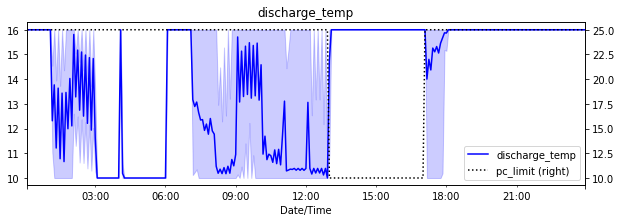

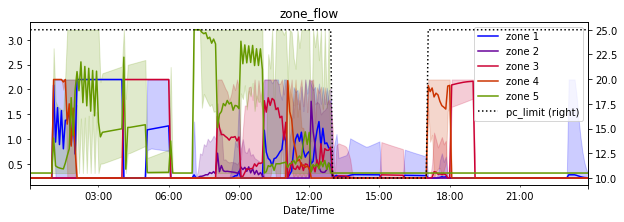

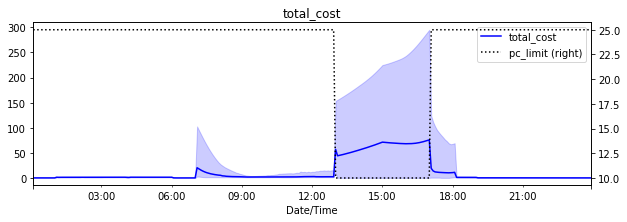

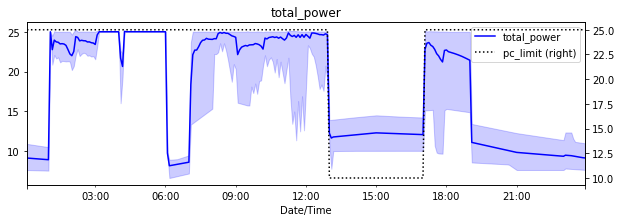

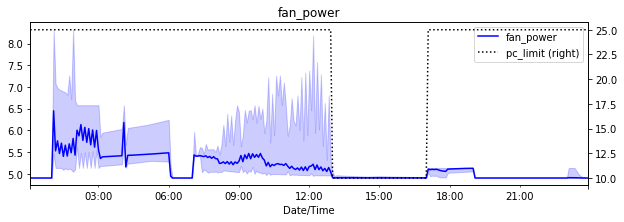

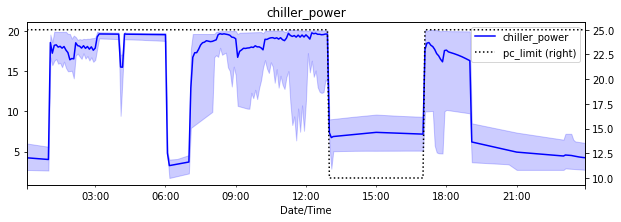

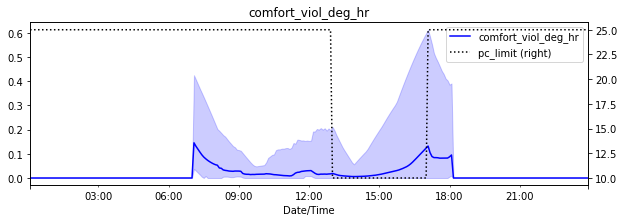

In [26]:
runner3 = CPLRunner(**config)
loss3, rollout3, meta3 = runner3.run()

_, df, figs = run_analysis(rollout3, dr, secondary=True)

# DPC

In [84]:
configs["DPC"]

{'name': 'DPC-PC-test',
 'policy_type': 'DPC',
 'batch_size': 5,
 'dr_program': 'PC',
 'scenario_config': {'start_time': '00:05:00',
  'end_time': '23:55:00',
  'zone_temp_init_mean': 26.0,
  'dr_program': <lbc.demand_response.DemandResponseProgram at 0x7f8506014b20>},
 'policy_config': {'model_config': {'hidden_dim': 128, 'num_time_windows': 24},
  'lr': 0.01,
  'num_epochs': 1000},
 'training': True,
 'dry_run': 0,
 'results_dir': './_scratch'}

1963.022, 2355.428,:  16%|████████████▎                                                               | 81/500 [02:07<10:59,  1.57s/it]
INFO:lbc.experiments.runner:[DPC-PC-test] bsz=5, loss=2154.998, time=127.5
INFO:lbc.experiments.runner:saved to ./_scratch/DPC-PC-test.p


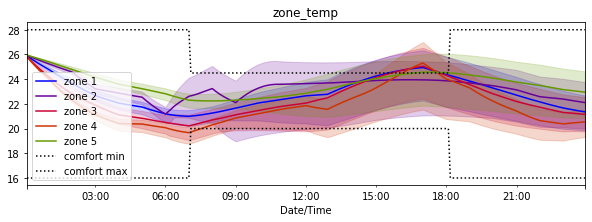

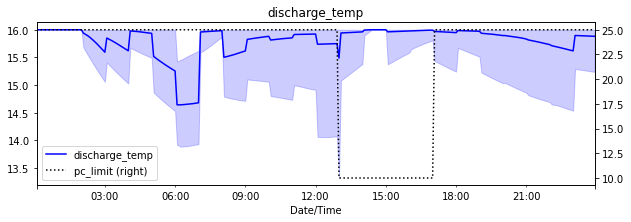

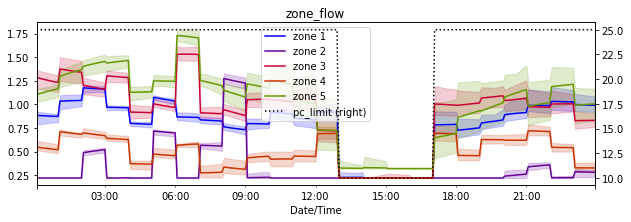

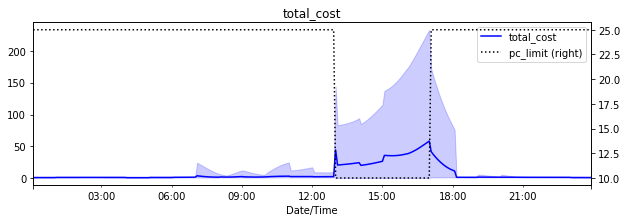

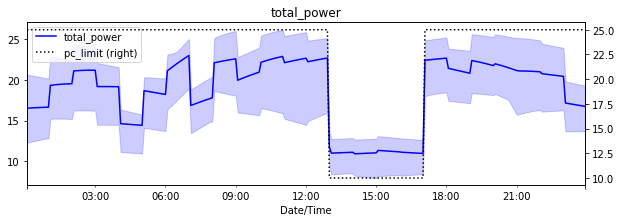

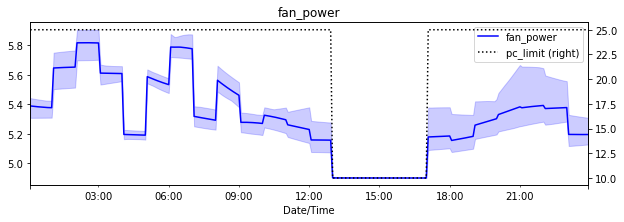

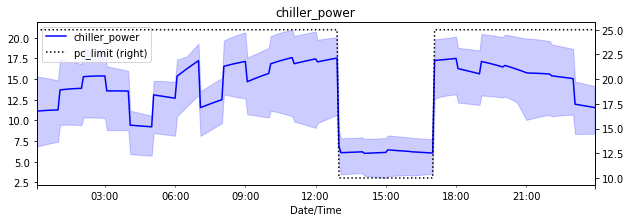

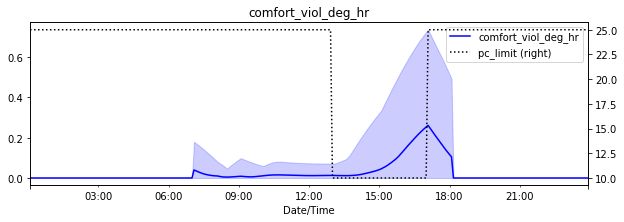

In [85]:
config = configs["DPC"]
config["policy_config"]["num_epochs"] = 500
config["policy_config"]["lr"] = 1e-3

runner4 = DPCRunner(**config)
loss4, rollout4, meta4 = runner4.run()

_, df, figs = run_analysis(rollout4, dr, secondary=True)

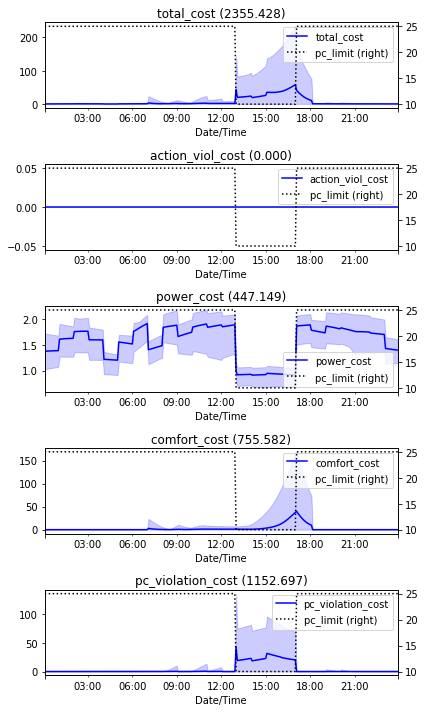

In [87]:
_ = plot_costs(rollout4, secondary="pc_limit")

# RLC

(RolloutWorker pid=56631) /Users/dbiagion/miniconda3/envs/lbc/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=56631)   logger.warn(
(RolloutWorker pid=56631) 2022-02-10 09:13:31,441	WARNING deprecation.py:45 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!
2022-02-10 09:13:35,042	INFO trainable.py:124 -- Trainable.setup took 11.552 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-02-10 09:13:35,045	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-02-10 09:13:36,053	INFO trainable.py:467 -- Restored on 127.0.0.1 from checkpoint: /Users/dbiagion/gitrepos/learning-building-control/lbc/policies/rlc_checkpoints/power_constrained/checkpoint/checkpoint
2022-02-10 09:13:36,097	INFO trainable.py:475 -- Current

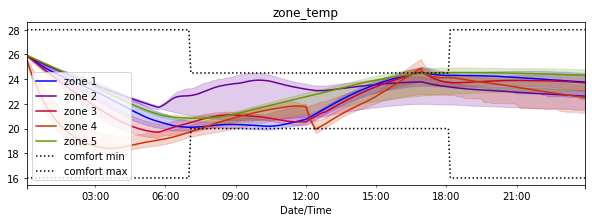

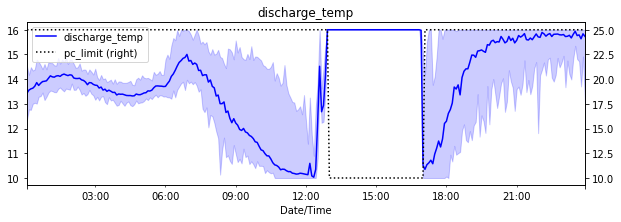

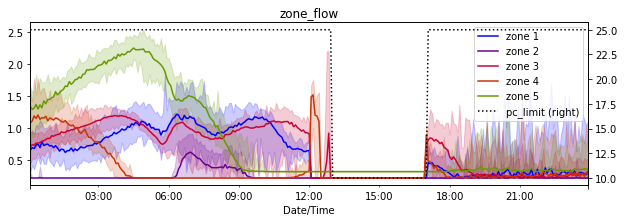

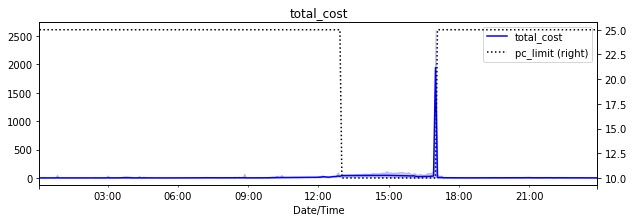

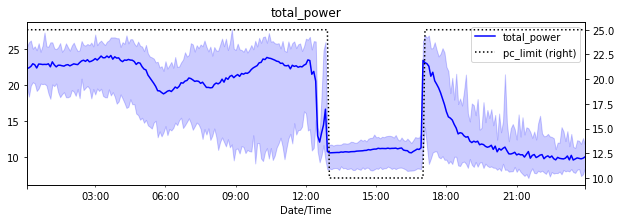

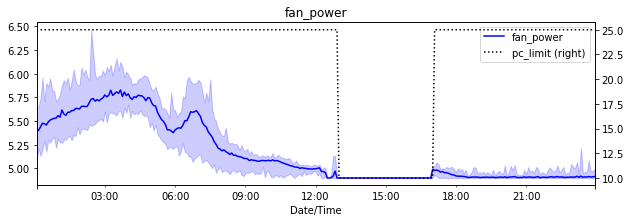

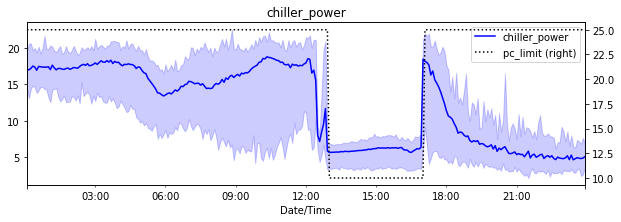

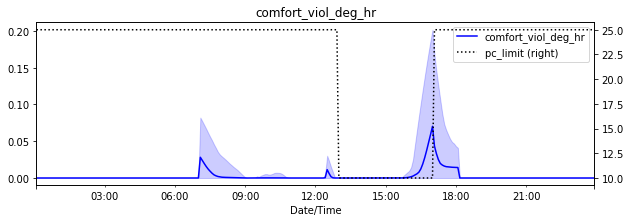

In [32]:
config = configs["RLC"]

# Shut down ray in case it's still running, fail silently
try:
    import ray
    ray.shutdown()
except:
    pass

runner5 = RLCRunner(**config)
loss5, rollout5, meta5 = runner5.run()

_, df, figs = run_analysis(rollout5, dr, secondary=True)